# 1. Load libraries, patient labels

In [2]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
import datetime
import multiprocessing as mp
import pickle
from functools import reduce

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# 2. Functions to load CT scans, transform 'color', resize 3d image, save and load transformed images

In [3]:
# Load the scans in given folder path
def load_CT_scan(path):
    slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices

In [4]:
def transform_into_hounsfield_units(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):
        
        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope
        
        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)
            
        image[slice_number] += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [5]:
def resample_size(image, scan, new_size = [64, 244, 244]):
    
    orig_size = image.shape # size [z,x,y] (x,y or y,x??)
    zoom = np.array(new_size, dtype=np.float32)/orig_size
    
    image = scipy.ndimage.interpolation.zoom(image, zoom, mode='nearest')
    
    return image

In [6]:
import bcolz
def save_array(fname, arr): c=bcolz.carray(arr, rootdir=fname, mode='w'); c.flush()
def load_array(fname): return bcolz.open(fname)[:]

In [7]:
def plot_3d(image, threshold=-300, showB = True):
    
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    if(showB == True):
        plt.show()
        
#     return fig

In [8]:
def save_image(image, fname, threshold = -200):
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)

    verts, faces = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.1)
    face_color = [0.5, 0.5, 1]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])
    fig.savefig(fname)
    plt.close()

# 3. Set directories, load patient labels

In [9]:
# Some constants 

data_root = '/Users/szalmaf/Documents/GitHub/Training Python/Kaggle_Data_Science_Bowl_2017/'
# data_dir = data_root + 'sample_images/'
data_dir = data_root + 'stage1/'
patients = os.listdir(data_dir)
patients.remove('.DS_Store')

patients.sort()
labels_df = pd.read_csv(data_root + 'stage1_labels.csv')
labels_df.head()
len(patients)
labels_df['id']

patients_df = pd.DataFrame(patients)
patients_df.to_csv(data_root + 'patient_labels.csv')

In [100]:
type(patients[0])

str

# 4. Check image 'color' distribution and image of a slice

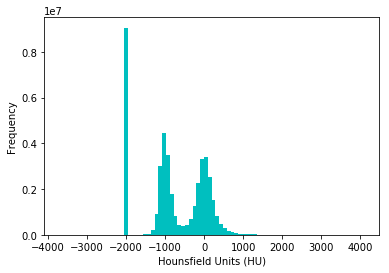

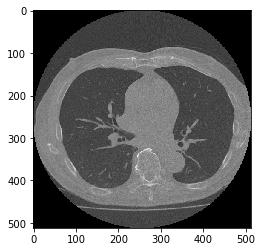

In [9]:
ct_scan = load_CT_scan(data_dir + patients[152])
ct_scan_image_HF = transform_into_hounsfield_units(ct_scan)
plt.hist(ct_scan_image_HF.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(ct_scan_image_HF[80], cmap=plt.cm.gray)
plt.show()

In [51]:
ct_scan_image_HF.shape

(161, 512, 512)

# 5. Load, transform, resize, save new images (multi-threaded)

In [11]:
# Single threaded code
# def fn(x):
#     ct_scan = load_CT_scan(data_dir + x)
#     ct_scan_image_HF = transform_into_hounsfield_units(ct_scan)
#     return resample_size(ct_scan_image_HF, ct_scan, [64, 244, 244])
# %time res = list(map(fn, patients[:2]))


CPU times: user 12.8 s, sys: 1.13 s, total: 13.9 s
Wall time: 14.4 s


In [11]:
image = res[0]
plt.hist(image.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(image[32], cmap=plt.cm.gray)
plt.show()

NameError: name 'res' is not defined

In [20]:
# Multi-threaded code; often works in Python 3.5
from multiprocessing import Pool
number_of_threads = 6
p = Pool(number_of_threads)

def fn(x):
    ct_scan = load_CT_scan(data_dir + x)
    ct_scan_image_HF = transform_into_hounsfield_units(ct_scan)
    return resample_size(ct_scan_image_HF, ct_scan, [64, 244, 244])
%time res = p.map(fn, patients)


/Users/szalmaf/anaconda/envs/kaggle2017/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/Users/szalmaf/anaconda/envs/kaggle2017/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/Users/szalmaf/anaconda/envs/kaggle2017/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:568: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
/Users/szalmaf/anaconda/envs/kaggle2017/

CPU times: user 19.6 s, sys: 3min 1s, total: 3min 21s
Wall time: 40min 43s


In [ ]:
%time resArr = np.stack([arr for arr in res])

In [25]:
str(resArr.shape[0])

'1595'

In [26]:
file_name = data_root + 'images_3d_array-' + str(resArr.shape[0]) + 'x64x244x244.bc'
file_name

'/Users/szalmaf/Documents/GitHub/Training Python/Kaggle_Data_Science_Bowl_2017/images_3d_array-1595x64x244x244.bc'

In [27]:
%time save_array(file_name, resArr)

CPU times: user 1min 1s, sys: 1min 8s, total: 2min 10s
Wall time: 2min 19s


# 6. Reload transformed images

In [9]:
resArr = load_array('/Users/szalmaf/Documents/GitHub/Training Python/Kaggle_Data_Science_Bowl_2017/images_3d_array-1595x64x244x244.bc')

In [10]:
resArr.nbytes

12154869760

In [11]:
del resArr

In [20]:
resArr10 = resArr[1001:]

In [21]:
file_name = data_root + 'images_3d_array-' + str(resArr10.shape[0]) + 'x64x244x244.bc'
file_name

'/Users/szalmaf/Documents/GitHub/Training Python/Kaggle_Data_Science_Bowl_2017/images_3d_array-594x64x244x244.bc'

In [22]:
%time save_array(file_name, resArr10)

CPU times: user 21.8 s, sys: 23.1 s, total: 44.9 s
Wall time: 28.8 s


In [ ]:
resArr100 = resArr[:100]

In [9]:
file_name = data_root + 'images_3d_array-' + str(resArr100.shape[0]) + 'x64x244x244.bc'
file_name

'/Users/szalmaf/Documents/GitHub/Training Python/Kaggle_Data_Science_Bowl_2017/images_3d_array-100x64x244x244.bc'

In [10]:
%time save_array(file_name, resArr10)

CPU times: user 1.16 s, sys: 171 ms, total: 1.34 s
Wall time: 1.07 s


# 7. Reload transformed images

In [10]:
resArr = load_array('/Users/szalmaf/Documents/GitHub/Training Python/Kaggle_Data_Science_Bowl_2017/images_3d_array-500x64x244x244.bc')

In [11]:
resArr.shape

(500, 64, 244, 244)

# 8. Plot images and save in png

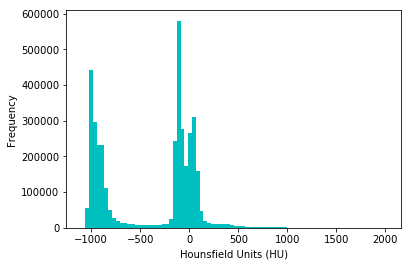

In [22]:
image3d = resArr[163]
plt.hist(image3d.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(image3d[32], cmap=plt.cm.gray)
plt.show()

In [48]:
patients[152]

'1a41350d4bbd74b7e0e28239cefa84c2'

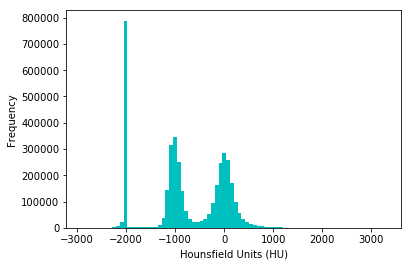

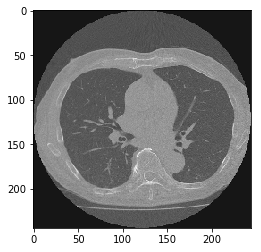

In [49]:
image3d = resArr[152]
plt.hist(image3d.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(image3d[32], cmap=plt.cm.gray)
plt.show()

In [12]:
resArr10.shape

(10, 64, 244, 244)

In [25]:
# Multi-threaded code; often works in Python 3.5

def fn(x, i):
    save_image(x, "img" + str(i) + ".png", -200)
    return 1

def multiprocess(processes, n, dn):
    pool = mp.Pool(processes=processes)
    results = [pool.apply_async(fn, args=(x, i)) for i, x in enumerate(resArr[n:n+dn], n)]
    results = [p.get() for p in results]
    pool.close()
    return results

print(datetime.datetime.now())
dn = 3
for n in range(200, 206, dn):
    multiprocess(6, n, dn)
    print(datetime.datetime.now())

2017-02-26 09:30:15.160456
2017-02-26 09:31:00.467621
2017-02-26 09:31:52.363333


In [14]:
# Multi-threaded code; often works in Python 3.5

p = mp.Pool(processes = 6)

def fn(x):
    save_image(x, "img25" + ".png", -200)
    
%time p.map(fn, resArr10)

CPU times: user 405 ms, sys: 423 ms, total: 828 ms
Wall time: 3min 3s


[None, None, None, None, None, None, None, None, None, None]

In [16]:
(image3d.min(), image3d.max())

(-1285, 3427)

In [34]:
image3d.ndim

3

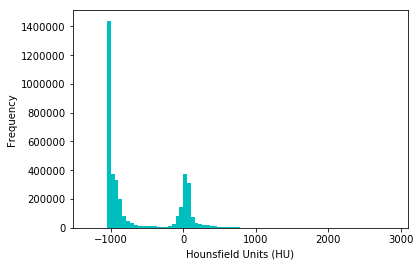

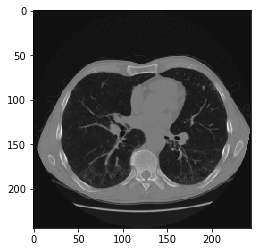

In [9]:
plt.hist(image3d.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
plt.imshow(image3d[32], cmap=plt.cm.gray)
plt.show()

# 10. Lung segmetation

In [11]:
def largest_label_volume(im, bg=-1):
    vals, counts = np.unique(im, return_counts=True)

    counts = counts[vals != bg]
    vals = vals[vals != bg]

    if len(counts) > 0:
        return vals[np.argmax(counts)]
    else:
        return None

def segment_lung_mask(image, fill_lung_structures=True):
    
    # not actually binary, but 1 and 2. 
    # 0 is treated as background, which we do not want
    binary_image = np.array(image > -320, dtype=np.int8)+1
    labels = measure.label(binary_image)
    
    # Pick the pixel in the very corner to determine which label is air.
    #   Improvement: Pick multiple background labels from around the patient
    #   More resistant to "trays" on which the patient lays cutting the air 
    #   around the person in half
    background_label = labels[0,0,0]
    
    #Fill the air around the person
    binary_image[background_label == labels] = 2
    
    
    # Method of filling the lung structures (that is superior to something like 
    # morphological closing)
    if fill_lung_structures:
        # For every slice we determine the largest solid structure
        for i, axial_slice in enumerate(binary_image):
            axial_slice = axial_slice - 1
            labeling = measure.label(axial_slice)
            l_max = largest_label_volume(labeling, bg=0)
            
            if l_max is not None: #This slice contains some lung
                binary_image[i][labeling != l_max] = 1

    
    binary_image -= 1 #Make the image actual binary
    binary_image = 1-binary_image # Invert it, lungs are now 1
    
    # Remove other air pockets insided body
    labels = measure.label(binary_image, background=0)
    l_max = largest_label_volume(labels, bg=0)
    if l_max is not None: # There are air pockets
        binary_image[labels != l_max] = 0
 
    return binary_image

CPU times: user 535 ms, sys: 45.7 ms, total: 581 ms
Wall time: 577 ms


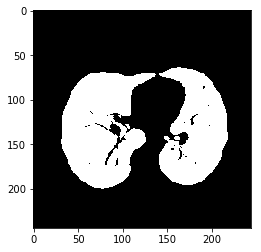

In [86]:
%time segmented_lungs = segment_lung_mask(resArr[0], False)
plt.imshow(segmented_lungs[32], cmap=plt.cm.gray)
plt.show()

CPU times: user 714 ms, sys: 48.3 ms, total: 762 ms
Wall time: 759 ms


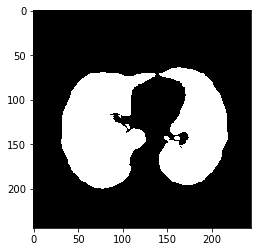

In [87]:
%time segmented_lungs_fill = segment_lung_mask(resArr[0], True)
plt.imshow(segmented_lungs_fill[32], cmap=plt.cm.gray)
plt.show()

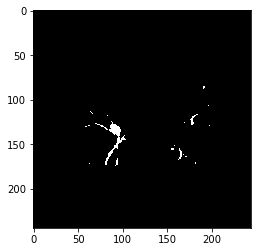

In [88]:
plt.imshow((segmented_lungs_fill-segmented_lungs)[32], cmap=plt.cm.gray)
plt.show()

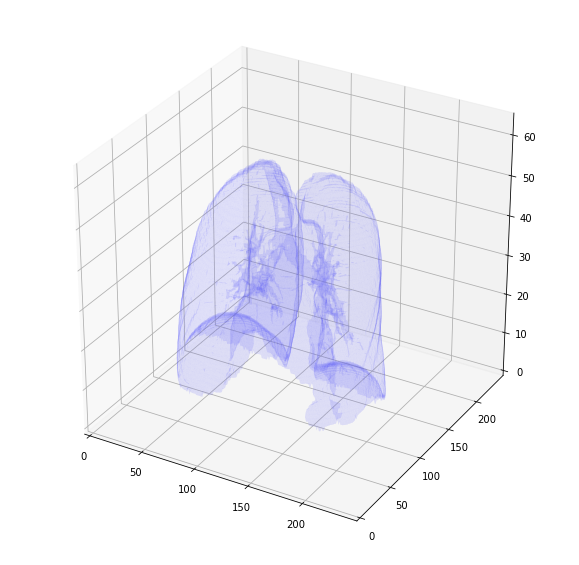

CPU times: user 20.6 s, sys: 1.68 s, total: 22.3 s
Wall time: 21.3 s


In [32]:
%time plot_3d(segmented_lungs, 0)

## Lung segmentation w/o fill

In [14]:
def fn(x):
    return segment_lung_mask(x, False)

p = mp.Pool(processes = 4)
%time res = p.map(fn, resArr[:1])
p.close()

sl = np.stack([arr for arr in res])
del res



CPU times: user 8.45 ms, sys: 20.3 ms, total: 28.8 ms
Wall time: 650 ms


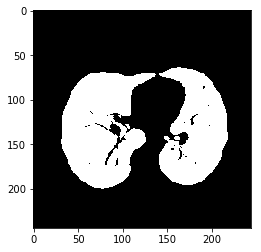

In [15]:
plt.imshow(sl[0][32], cmap=plt.cm.gray)
plt.show()

In [17]:
save_array(data_root + 'segment_lung_594', sl)

## Lung segmentation w/ fill

In [31]:
def fn(x):
    return segment_lung_mask(x, True)

p = mp.Pool(processes = 4)
%time res = p.map(fn, resArr)
p.close()

slf = np.stack([arr for arr in res])
del res



CPU times: user 6.82 s, sys: 1min 54s, total: 2min
Wall time: 3min 37s


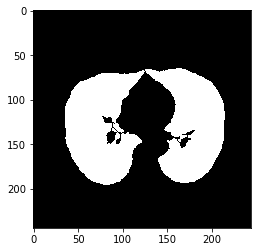

In [32]:
plt.imshow(slf[0][32], cmap=plt.cm.gray)
plt.show()

In [33]:
slf.shape

(594, 64, 244, 244)

In [34]:
save_array(data_root + 'segment_lung_fill_594', slf)

### Lung segmentation algorithm taken apart to examine it in detail

In [35]:
sl = load_array(data_root + 'segment_lung_500')
slf = load_array(data_root + 'segment_lung_fill_500')

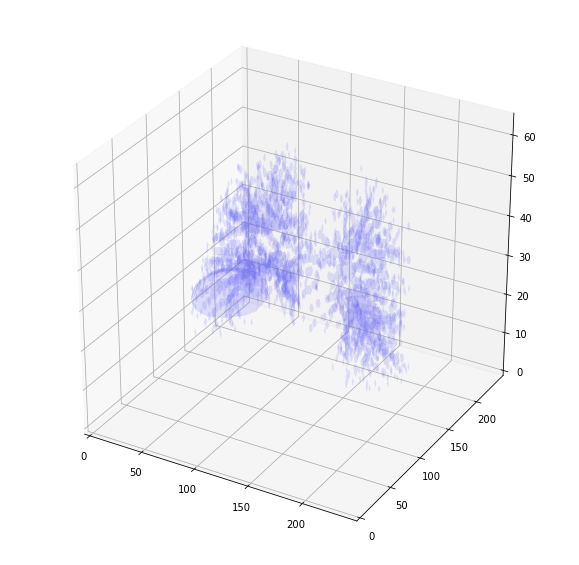

In [41]:
imgN = 5
plot_3d(slf[imgN]-sl[imgN],0)

In [52]:
def fn(i):
    s=(sl[i])
    return (s.min(), s.max())
list(map(fn, range(0,sl.shape[0]))) 

[(0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 

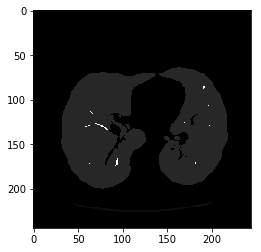

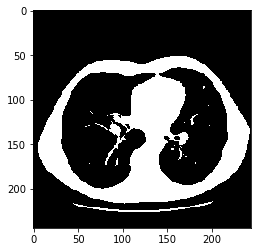

In [78]:
image = resArr[0]
# not actually binary, but 1 and 2. 
# 0 is treated as background, which we do not want
binary_image = np.array(image > -320, dtype=np.int8)+1
labels = measure.label(binary_image)

plt.imshow(labels[32], cmap=plt.cm.gray)
plt.show()
plt.imshow(binary_image[32], cmap=plt.cm.gray)
plt.show()

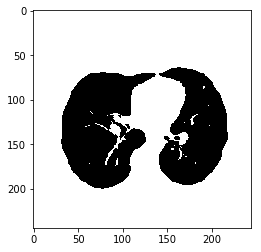

In [79]:
# Pick the pixel in the very corner to determine which label is air.
#   Improvement: Pick multiple background labels from around the patient
#   More resistant to "trays" on which the patient lays cutting the air 
#   around the person in half
background_label = labels[0,0,0]

#Fill the air around the person: black 1, white 2
binary_image[background_label == labels] = 2
plt.imshow(binary_image[32], cmap=plt.cm.gray)
plt.show()

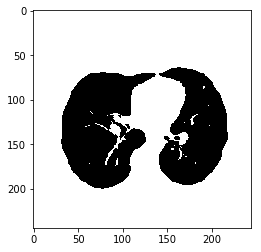

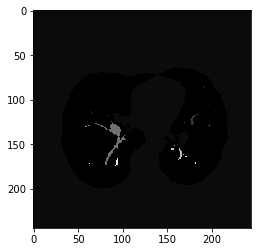

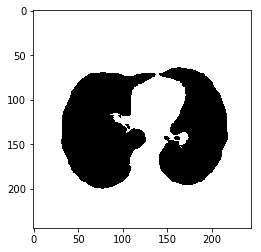

1


In [81]:
# Method of filling the lung structures (that is superior to something like 
# morphological closing)
# For every slice we determine the largest solid structure

# for i, axial_slice in enumerate(binary_image):
axial_slice = binary_image[32]
axial_slice = axial_slice - 1
labeling = measure.label(axial_slice)
l_max = largest_label_volume(labeling, bg=0)

if l_max is not None: #This slice contains some lung
    binary_image[32][labeling != l_max] = 1

plt.imshow(axial_slice, cmap=plt.cm.gray)
plt.show()
plt.imshow(labeling, cmap=plt.cm.gray)
plt.show()
plt.imshow(binary_image[32], cmap=plt.cm.gray)
plt.show()

print(l_max)

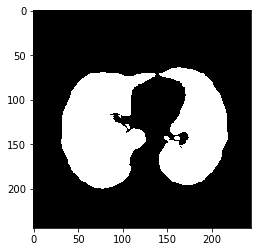

In [82]:
binary_image -= 1 #Make the image actual binary
binary_image = 1-binary_image # Invert it, lungs are now 1

# Remove other air pockets insided body
labels = measure.label(binary_image, background=0)
l_max = largest_label_volume(labels, bg=0)
if l_max is not None: # There are air pockets
    binary_image[labels != l_max] = 0

plt.imshow(binary_image[32], cmap=plt.cm.gray)
plt.show()



In [54]:
sl.nbytes

1905152000

## Save lung segmentation images

In [42]:
sl.shape

(500, 64, 244, 244)

In [45]:
def fn(x, i):
    save_image(x, data_root + "/segmented_lung_diff_images/img" + str(i) + ".png", 0)
    return 1

def multiprocess(processes, n, dn):
    pool = mp.Pool(processes=processes)
    results = [pool.apply_async(fn, args=(x, i)) for i, x in enumerate(slf[n:n+dn]-sl[n:n+dn], n)]
    results = [p.get() for p in results]
    pool.close()
    return results

print(datetime.datetime.now())
# startn = 1001
# endn = 1594
startn = 145
endn = 500

dn = 24
processes = 6
for n in range(startn, endn, dn):
    multiprocess(processes, n, dn)
    print(datetime.datetime.now())

2017-02-27 23:47:43.451840


IndexError: arrays used as indices must be of integer (or boolean) type

In [12]:
def fn(x, i):
    plt.hist(x.flatten(), bins=80, color='c')
    plt.xlabel("Hounsfield Units (HU)")
    plt.ylabel("Frequency")
    # plt.show()
    plt.savefig(data_root + "/orig_image_histogram/hist" + str(i) + ".png")
    return 1

def multiprocess(processes, n, dn):
    pool = mp.Pool(processes=processes)
    results = [pool.apply_async(fn, args=(x, i)) for i, x in enumerate(resArr[n:n+dn], n)]
    results = [p.get() for p in results]
    pool.close()
    return results

print(datetime.datetime.now())
startn = 0
endn = 1600
dn = 24
processes = 6
for n in range(startn, endn, dn):
    multiprocess(processes, n, dn)
    print(datetime.datetime.now())

2017-02-27 18:59:49.768053
2017-02-27 18:59:52.985305
2017-02-27 18:59:55.981812
2017-02-27 18:59:59.099518
2017-02-27 19:00:02.040386
2017-02-27 19:00:04.983155
2017-02-27 19:00:07.957754
2017-02-27 19:00:11.002422
2017-02-27 19:00:13.922582
2017-02-27 19:00:16.843401
2017-02-27 19:00:19.789931
2017-02-27 19:00:23.043052
2017-02-27 19:00:26.089473
2017-02-27 19:00:29.088353
2017-02-27 19:00:32.117342
2017-02-27 19:00:35.145037
2017-02-27 19:00:38.211098
2017-02-27 19:00:41.474881
2017-02-27 19:00:44.500710
2017-02-27 19:00:47.656918
2017-02-27 19:00:50.834385
2017-02-27 19:00:53.988905
2017-02-27 19:00:57.143434
2017-02-27 19:01:00.307752
2017-02-27 19:01:03.662360
2017-02-27 19:01:06.892417
2017-02-27 19:01:10.143840
2017-02-27 19:01:13.391362
2017-02-27 19:01:16.963006
2017-02-27 19:01:20.200069
2017-02-27 19:01:23.577570
2017-02-27 19:01:26.992568
2017-02-27 19:01:30.328700
2017-02-27 19:01:33.661050
2017-02-27 19:01:36.897004
2017-02-27 19:01:40.158979
2017-02-27 19:01:43.648364
2

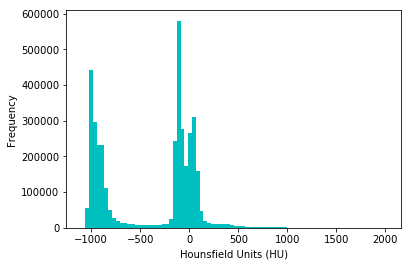

In [25]:
plt.hist(image3d.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
# plt.show()
plt.savefig(data_root + "/orig_image_histogram/hist" + str(i) + ".png")

In [18]:
import gc

# Use only patients w/ labels

In [111]:
len(patients_df)

1595

In [109]:
len(labels_df)

1397

In [115]:
patients_df.columns = ['id']

In [121]:
labels_df

,id,cancer
0,0015ceb851d7251b8f399e39779d1e7d,1
1,0030a160d58723ff36d73f41b170ec21,0
2,003f41c78e6acfa92430a057ac0b306e,0
3,006b96310a37b36cccb2ab48d10b49a3,1
4,008464bb8521d09a42985dd8add3d0d2,1
5,0092c13f9e00a3717fdc940641f00015,0
6,00986bebc45e12038ef0ce3e9962b51a,0
7,00cba091fa4ad62cc3200a657aeb957e,0
8,00edff4f51a893d80dae2d42a7f45ad1,1
9,0121c2845f2b7df060945b072b2515d7,0


In [116]:
patients_df

,id
0,0015ceb851d7251b8f399e39779d1e7d
1,0030a160d58723ff36d73f41b170ec21
2,003f41c78e6acfa92430a057ac0b306e
3,006b96310a37b36cccb2ab48d10b49a3
4,008464bb8521d09a42985dd8add3d0d2
5,0092c13f9e00a3717fdc940641f00015
6,00986bebc45e12038ef0ce3e9962b51a
7,00cba091fa4ad62cc3200a657aeb957e
8,00edff4f51a893d80dae2d42a7f45ad1
9,0121c2845f2b7df060945b072b2515d7


In [124]:
patients_all_df = pd.merge(patients_df, labels_df, left_on='id', right_on='id', how='outer')

In [128]:
patients_all_df

,id,cancer,fnameOld
0,0015ceb851d7251b8f399e39779d1e7d,1.0,img0.png
1,0030a160d58723ff36d73f41b170ec21,0.0,img1.png
2,003f41c78e6acfa92430a057ac0b306e,0.0,img2.png
3,006b96310a37b36cccb2ab48d10b49a3,1.0,img3.png
4,008464bb8521d09a42985dd8add3d0d2,1.0,img4.png
5,0092c13f9e00a3717fdc940641f00015,0.0,img5.png
6,00986bebc45e12038ef0ce3e9962b51a,0.0,img6.png
7,00cba091fa4ad62cc3200a657aeb957e,0.0,img7.png
8,00edff4f51a893d80dae2d42a7f45ad1,1.0,img8.png
9,0121c2845f2b7df060945b072b2515d7,0.0,img9.png


In [127]:
patients_all_df['fnameOld'] = ['img' + str(i) + '.png' for i in range(len(patients_all_df))]

In [147]:
df = patients_all_df.dropna(subset=["cancer"])

In [148]:
df['fnameNew'] = ['img' + str(i) + '.png' for i in range(len(df))]

/Users/szalmaf/anaconda/envs/kaggle2017/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [150]:
?os.rename(data_root)

In [167]:
def fn(x,y):
    os.rename(data_root + 'resampled_images/' + x, data_root + 'resampled_images2/' + y)
[fn(x,y) for x,y in zip(df['fnameOld'], df['fnameNew'])]

FileNotFoundError: [Errno 2] No such file or directory: '/Users/szalmaf/Documents/GitHub/Training Python/Kaggle_Data_Science_Bowl_2017/resampled_images/img1574.png' -> '/Users/szalmaf/Documents/GitHub/Training Python/Kaggle_Data_Science_Bowl_2017/resampled_images2/img1379.png'

In [168]:
def fn(x,y):
    os.rename(data_root + 'segmented_lung_images/' + x, data_root + 'segmented_lung_images2/' + y)
[fn(x,y) for x,y in zip(df['fnameOld'], df['fnameNew'])]

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

# Erosion and dilation

In [ ]:
http://scikit-image.org/docs/dev/api/skimage.morphology.html #skimage.morphology.binary_erosion

# Normalization and zero centering

In [ ]:
See Full pre-processing tutorial

# Collapsing into 4 images, each image contain bit of gray scale

In [11]:
image = resArr[0]

In [24]:
lower_bound = -511
upper_bound = 512
image[np.logical_or(image<-lower_bound, image>upper_bound)] = -1000

In [27]:
type(image[0][0][0])

numpy.int16

In [28]:
image[0][0][0]

-1000

#### Lets have a (-512,511) range 10 bit integer stored in a 16 bit integer

In [44]:
np.binary_repr(511, width=16)

'0000000111111111'

In [45]:
np.binary_repr(-512, width=16)

'1111111000000000'

#### Reduce it to 4 bits, which means taking the top 4 bits of the 10 bits: (x & 0000 0011 1100 0000) that is (x & 960).

In [50]:
np.binary_repr(511 & 960, width=16)

'0000000111000000'

In [51]:
np.binary_repr(-512 & 960, width=16)

'0000001000000000'

CPU times: user 12.4 s, sys: 5.21 s, total: 17.6 s
Wall time: 17.6 s


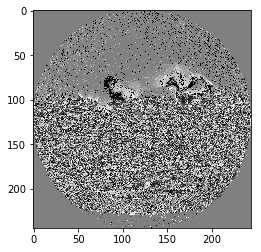

In [81]:
img3d = resArr[0]
# bit = 9 # Zero based! 6, 7, 8, 9 bits are the relevant ones for us for 4 bit resolution

def bitShift(x, bits):
    if bits > 0:
        newx = x << bits
        return newx
    else:
        newx = x >> -bits
        return newx


def collapse3dto2d(img3d, bit):
    
    def fn(acc, x):
         return (acc[0] + 1, np.bitwise_or(acc[1], bitShift(x[1], acc[0]-bit))) # 'bit' is global here!

    bitMask = 2**bit
    maskedImg = np.array(img3d & bitMask, dtype = np.int64)
    
    xN = img3d.shape[1]
    yN = img3d.shape[2]
    empty2dImg = np.zeros((xN,yN), dtype=np.int64)
    
    n, img2d64 = reduce(fn, enumerate(maskedImg[:64]), (0, empty2dImg))
    return img2d64

def collapse(image):
    def coll(x): return collapse3dto2d(image, x)
    return np.stack(map(coll, range(6,10)))
%time allCollapsed = np.stack(map(collapse, resArr[:200]))

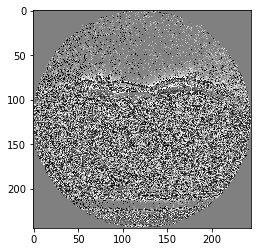

In [83]:
plt.imshow(sum(allCollapsed[100]), cmap=plt.cm.gray)
plt.show()

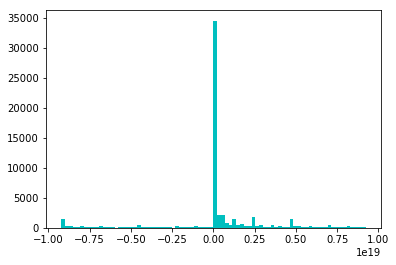

In [37]:
plt.hist(img2d64.flatten(), bins=80, color='c')
# plt.xlabel("Hounsfield Units (HU)")
# plt.ylabel("Frequency")
plt.show()